# Simple Driver Classification using "Long" Stops

### Table of Contents
* 1 Basic Information
    * 1.1 How many days of data do we have?
    * 1.2 How many stop points per day?
    * 1.3 How many "long" stops per day?
    * 1.4 What percentage of "long" stops in the driver's home city? 
    
    
* 2 Driver Classification
    * 2.1 **Short-haul**
    * 2.2 **Long-haul**

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
warnings.filterwarnings(action='ignore')

In [24]:
# Plot functions
def df_plot(data,xlabel,ylabel='Count',title=None,legend=False,plotstyle='bar',hist_max=20,bins=100,figscale=1):
    fig = plt.figure(figsize=(7*figscale,3*figscale))
    ax = plt.axes()
    if plotstyle=='bar':
        data.plot.bar(ax=ax,legend=legend)
    elif plotstyle=='hist':
        plt.hist(data,bins=bins,range=(data.min(),hist_max))
    ax.set_xlabel(xlabel,fontsize='small',fontweight='bold')
    if ylabel is not None: ax.set_ylabel(ylabel,fontsize='small',fontweight='bold')
    ax.xaxis.set_tick_params(labelsize='small')
    ax.yaxis.set_tick_params(labelsize='small')
    ax.set_title(title)
    plt.tight_layout()
    plt.show()
    
plt.style.use('ggplot')
mpl.rcParams['figure.dpi'] = 500
plt.rcParams['text.color'] = '#2D2D2D'

## 1 Basic Information about our Data
* See [this notebook](http://nbviewer.jupyter.org/github/edmondchensj/jupyter/blob/master/dr900_datavis.ipynb) for stop point criteria.

## 1.1 How many days of data do we have? 
* Most drivers have around **50 days** of data collected. 
* 大多数司机有50天的数据。

In [4]:
# Load data with stop points
sp_df = pd.read_csv('../../data/data_with_sp.csv')
sp_df['datetime'] = pd.to_datetime(sp_df['datetime'])

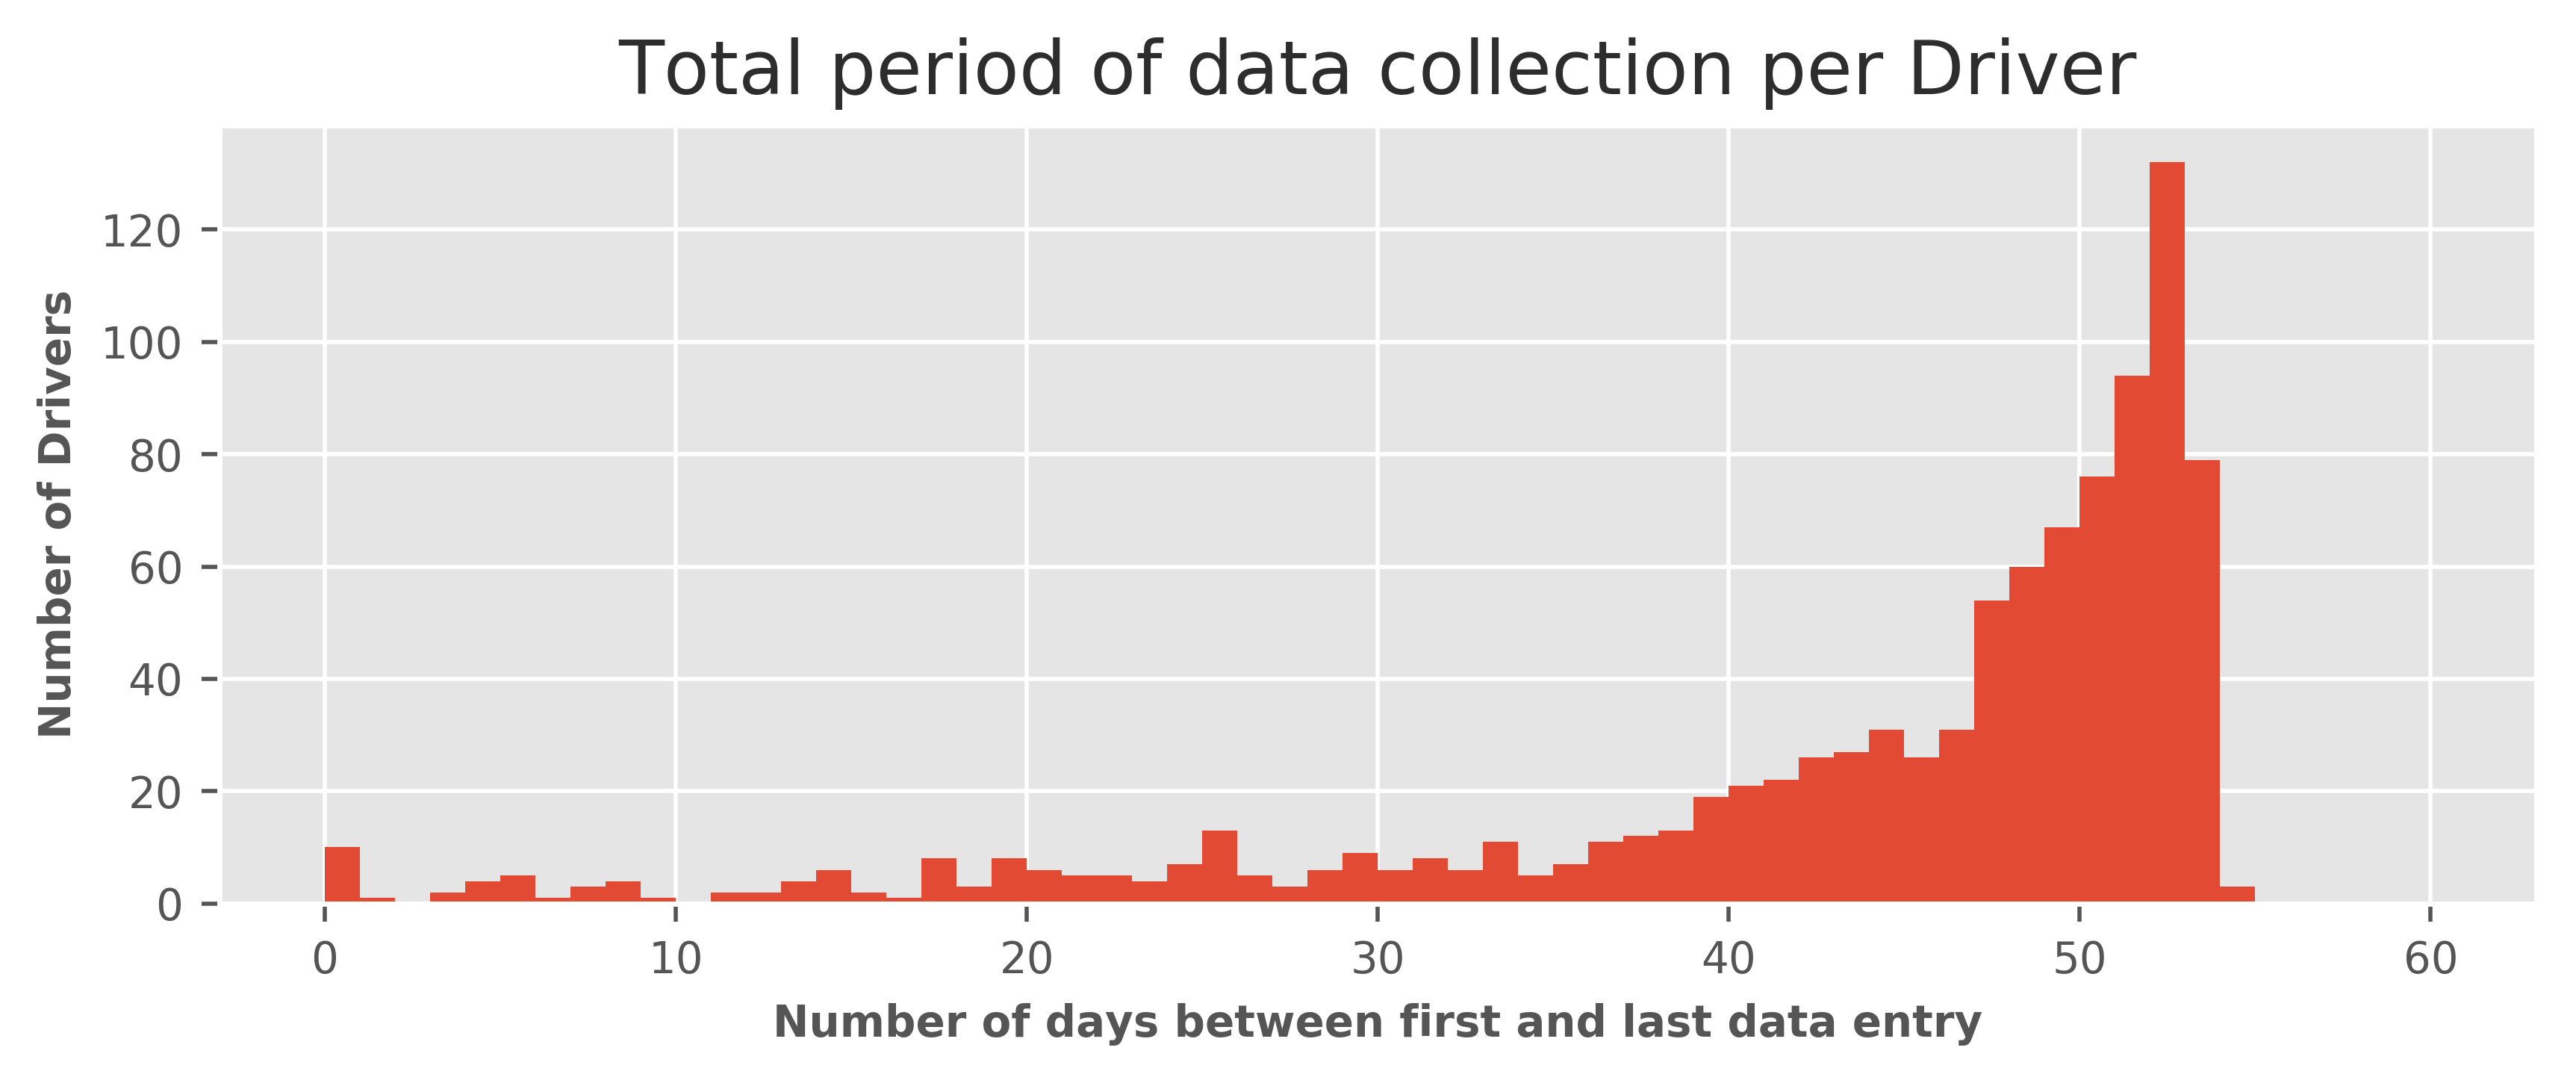

mean      43.18
median    48.00
min        0.00
max       54.00
std       11.85
dtype: float64


In [25]:
def days_per_user(user_df):
    col = user_df.columns.get_loc('datetime')
    return (user_df.iloc[-1,col] - user_df.iloc[0,col]).days

total_period = sp_df.groupby('userid').apply(lambda x: days_per_user(x))
df_plot(total_period,'Number of days between first and last data entry','Number of Drivers','Total period of data collection per Driver',plotstyle='hist',hist_max=60,bins=60)
print(total_period.agg(['mean','median','min','max','std']).round(2))

## 1.2 How many stop points per day? 
* Strangely, many drivers have an average of **less than 1 stop point per day**. 
* One reason could be that **on some days, no data were collected**. 


* 但是，司机们的某些日子缺少数据，导致平均停留次数少于一。 

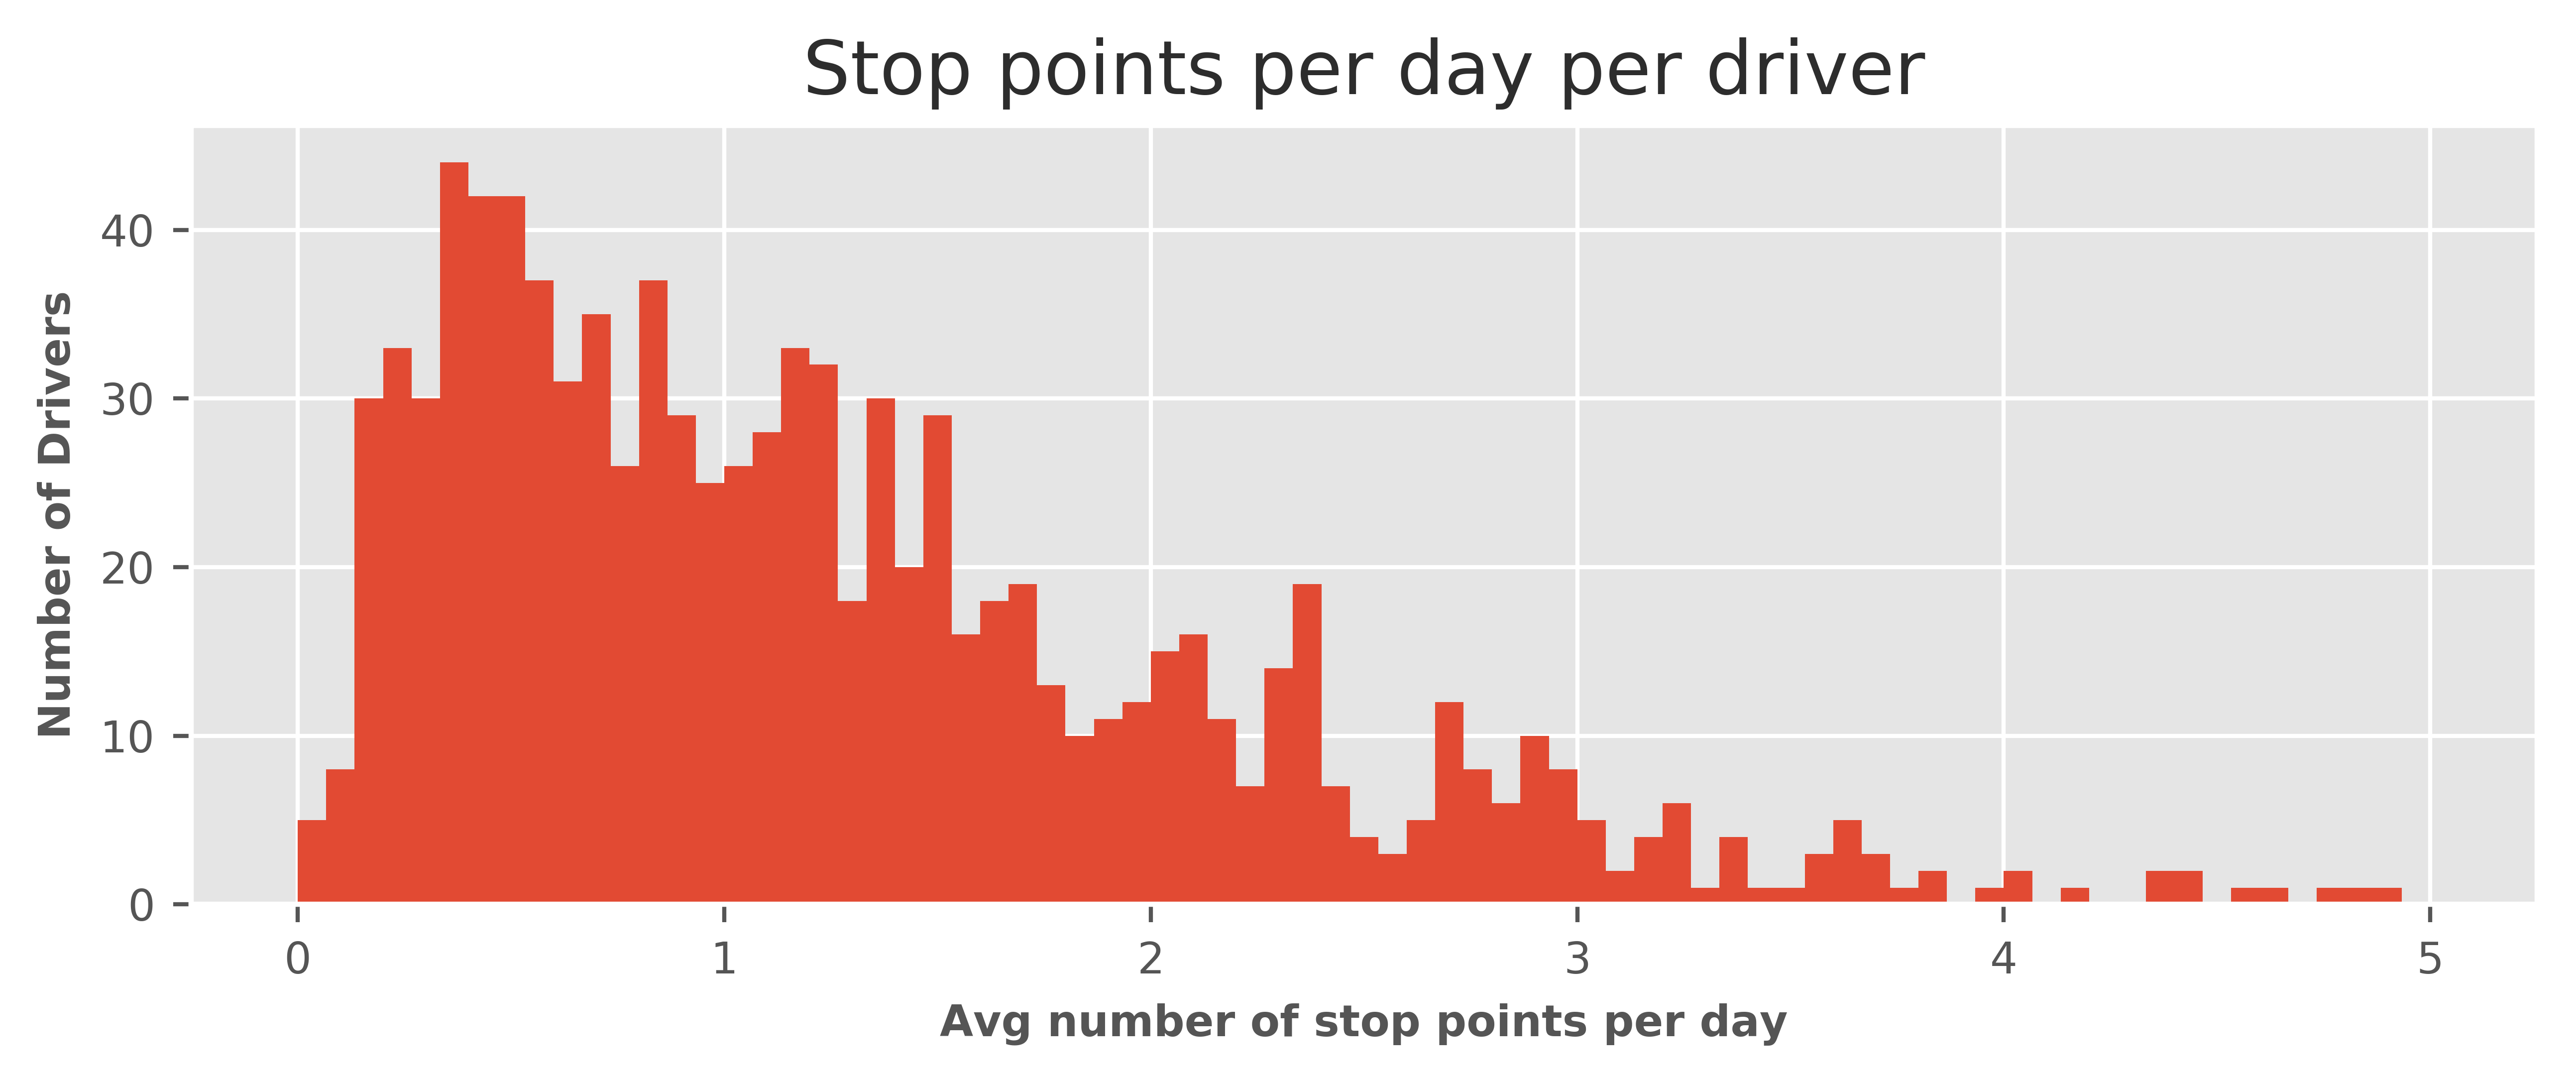

mean       1.29
median     1.08
min        0.00
max       11.31
std        0.98
dtype: float64


In [6]:
# Average number of stop points per day per user
def sp_per_day(user_df):
    num_days = days_per_user(user_df)
    if num_days==0: return np.nan
    num_sp = user_df.stop_pt.sum()
    return num_sp/num_days

avg_sp = sp_df.groupby('userid').apply(lambda x: sp_per_day(x))
df_plot(avg_sp,'Avg number of stop points per day','Number of Drivers','Stop points per day per driver',plotstyle='hist',hist_max=5,bins=75)
print(avg_sp.agg(['mean','median','min','max','std']).round(2))

## 1.3 How many long stops per day? 
* The number of long stops per day is around **0.3 per day** with std dev of 0.24. 
* The reason why this is below 1 per day may be the **missing data on certain days**, as stated above.


* 长停留平均次数在0.3左右。

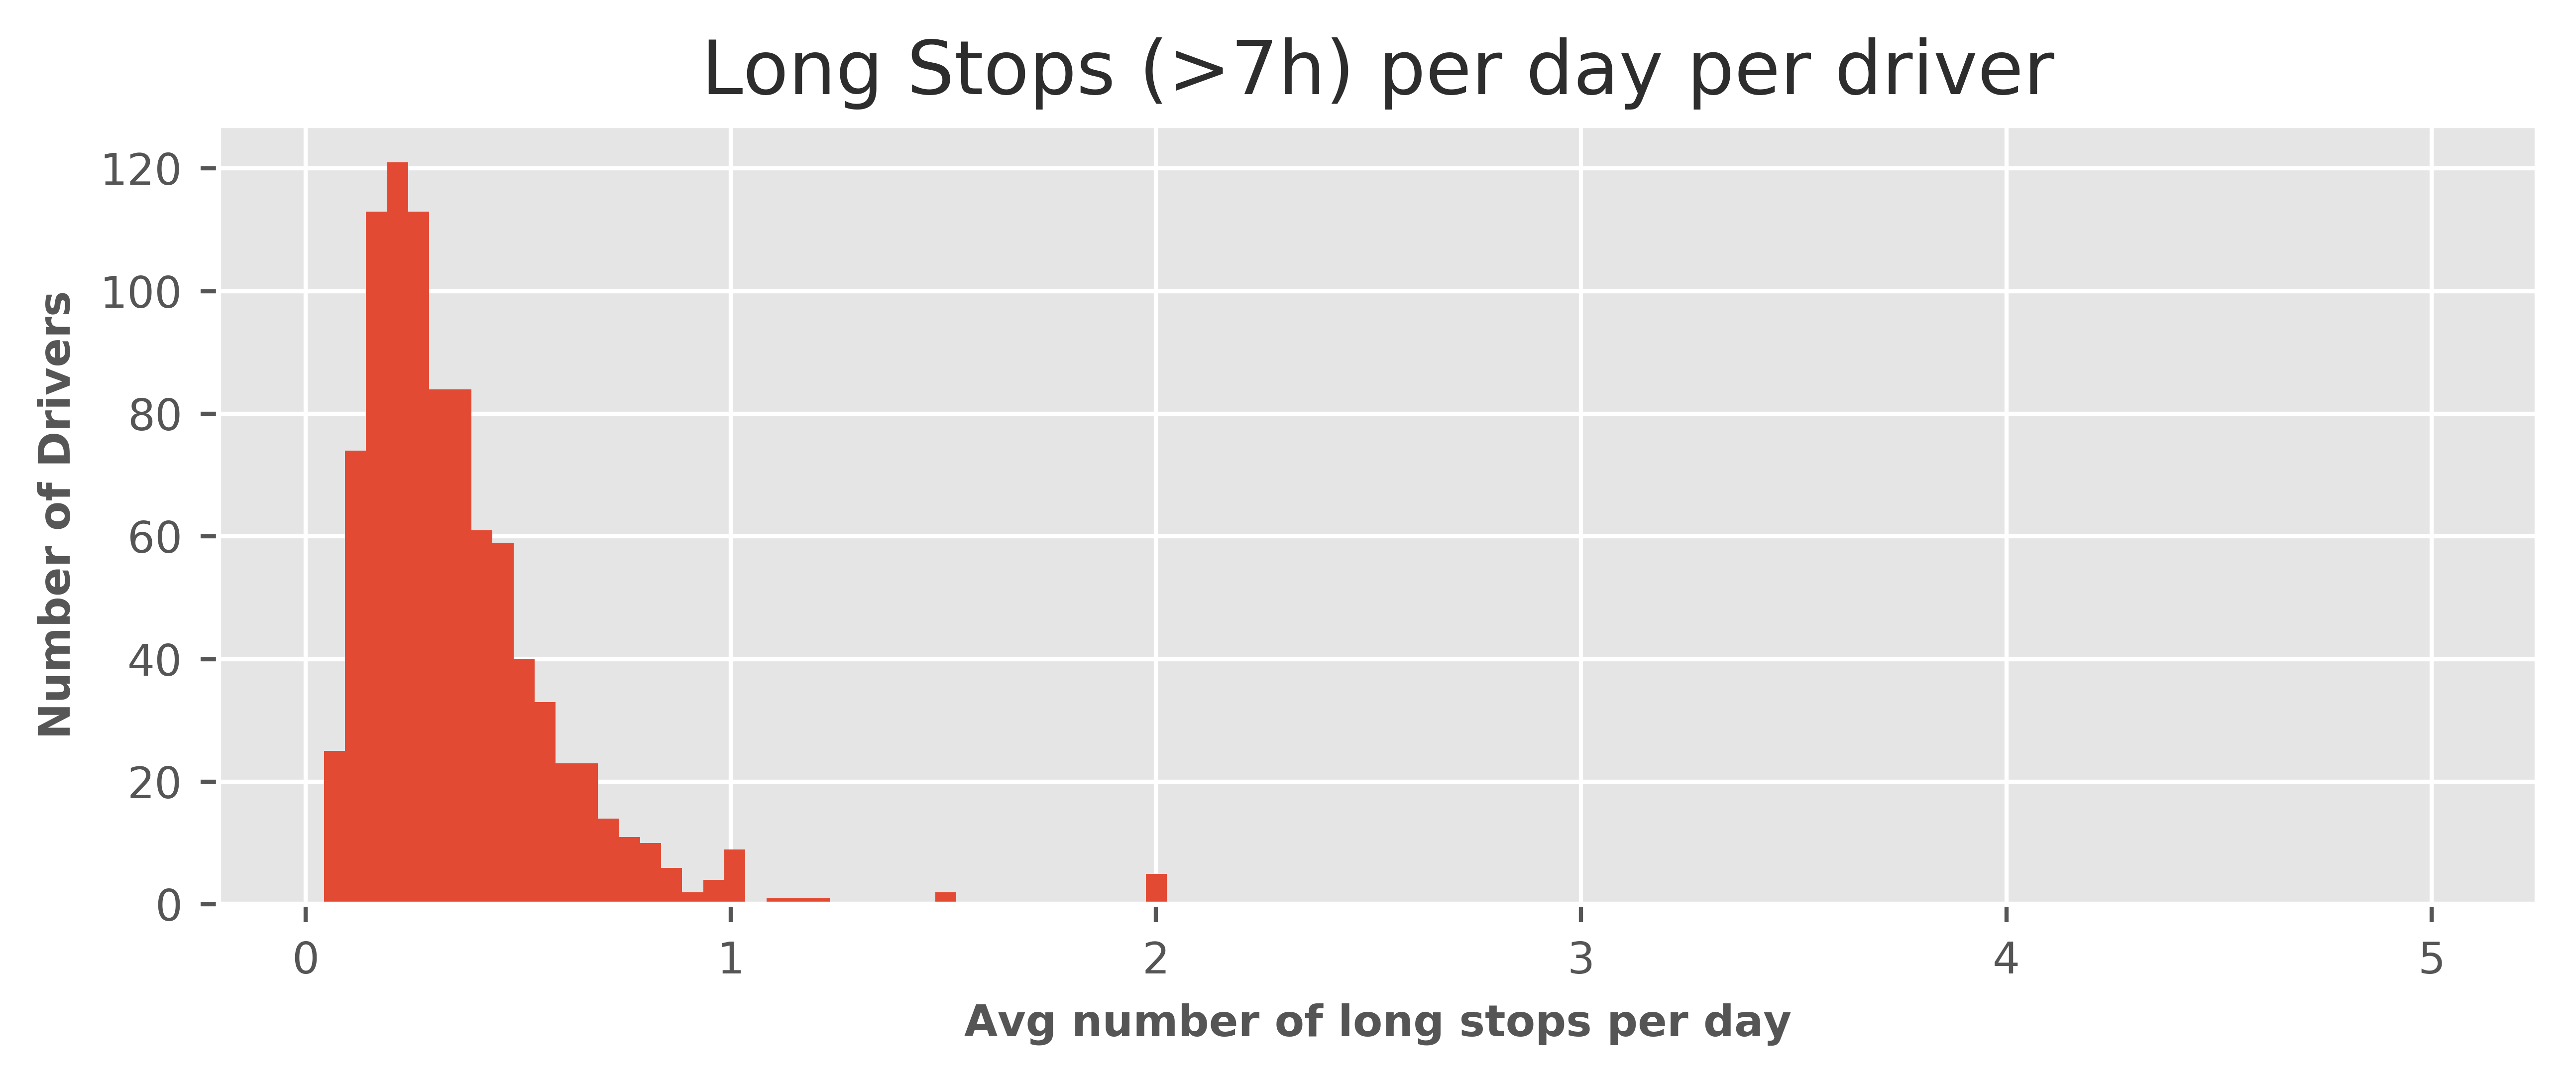

mean      0.35
median    0.30
min       0.04
max       2.00
std       0.24
dtype: float64


In [9]:
min_dur = 7
long_sp_df = sp_df[sp_df.stop_duration>min_dur]
avg_long_sp = long_sp_df.groupby('userid').apply(lambda x: sp_per_day(x))
df_plot(avg_long_sp,'Avg number of long stops per day','Number of Drivers',f'Long Stops (>{min_dur}h) per day per driver',plotstyle='hist',hist_max=5,bins=100)
print(avg_long_sp.agg(['mean','median','min','max','std']).round(2))

In [7]:
# Uncomment below to show total number of long stops per driver. 
#total_long_sp = long_sp_df.groupby('userid').apply(lambda x: x.shape[0])
#df_plot(total_long_sp,'Total number of long stops','Number of Drivers',f'Total Long Stops (>{min_dur}h) per driver',plotstyle='hist',hist_max=60,bins=60)
#print(total_long_sp.agg(['mean','median','min','max','std']).round(2))

## 1.4 What percentage of long stops (> 7h) are in the drivers' home cities? 
* Criteria for "home city": City with highest number of long stops. 
* Many drivers have **100% of long stops in their home city**. 


* "Home City"指的是司机长停留最多次的城市。 

In [10]:
# Helper script
import classify as clf

city_df = clf.load_cities('../../data/cargo_cities.csv')

# This will take a while because we need to calculate distances between stop point and cities.
user_city_df = clf.get_ls_cities(sp_df,city_df,min_dur)

Getting long stop cities ... 
Function get_ls_cities took 331.34s.


In [11]:
# Filter out users with less than a certain number of long stops,
# to remove anomalies in data. 
min_ls = 10
uc_df = user_city_df.copy()
uc_df.loc[uc_df.sum(axis=1)<min_ls,:] = np.nan

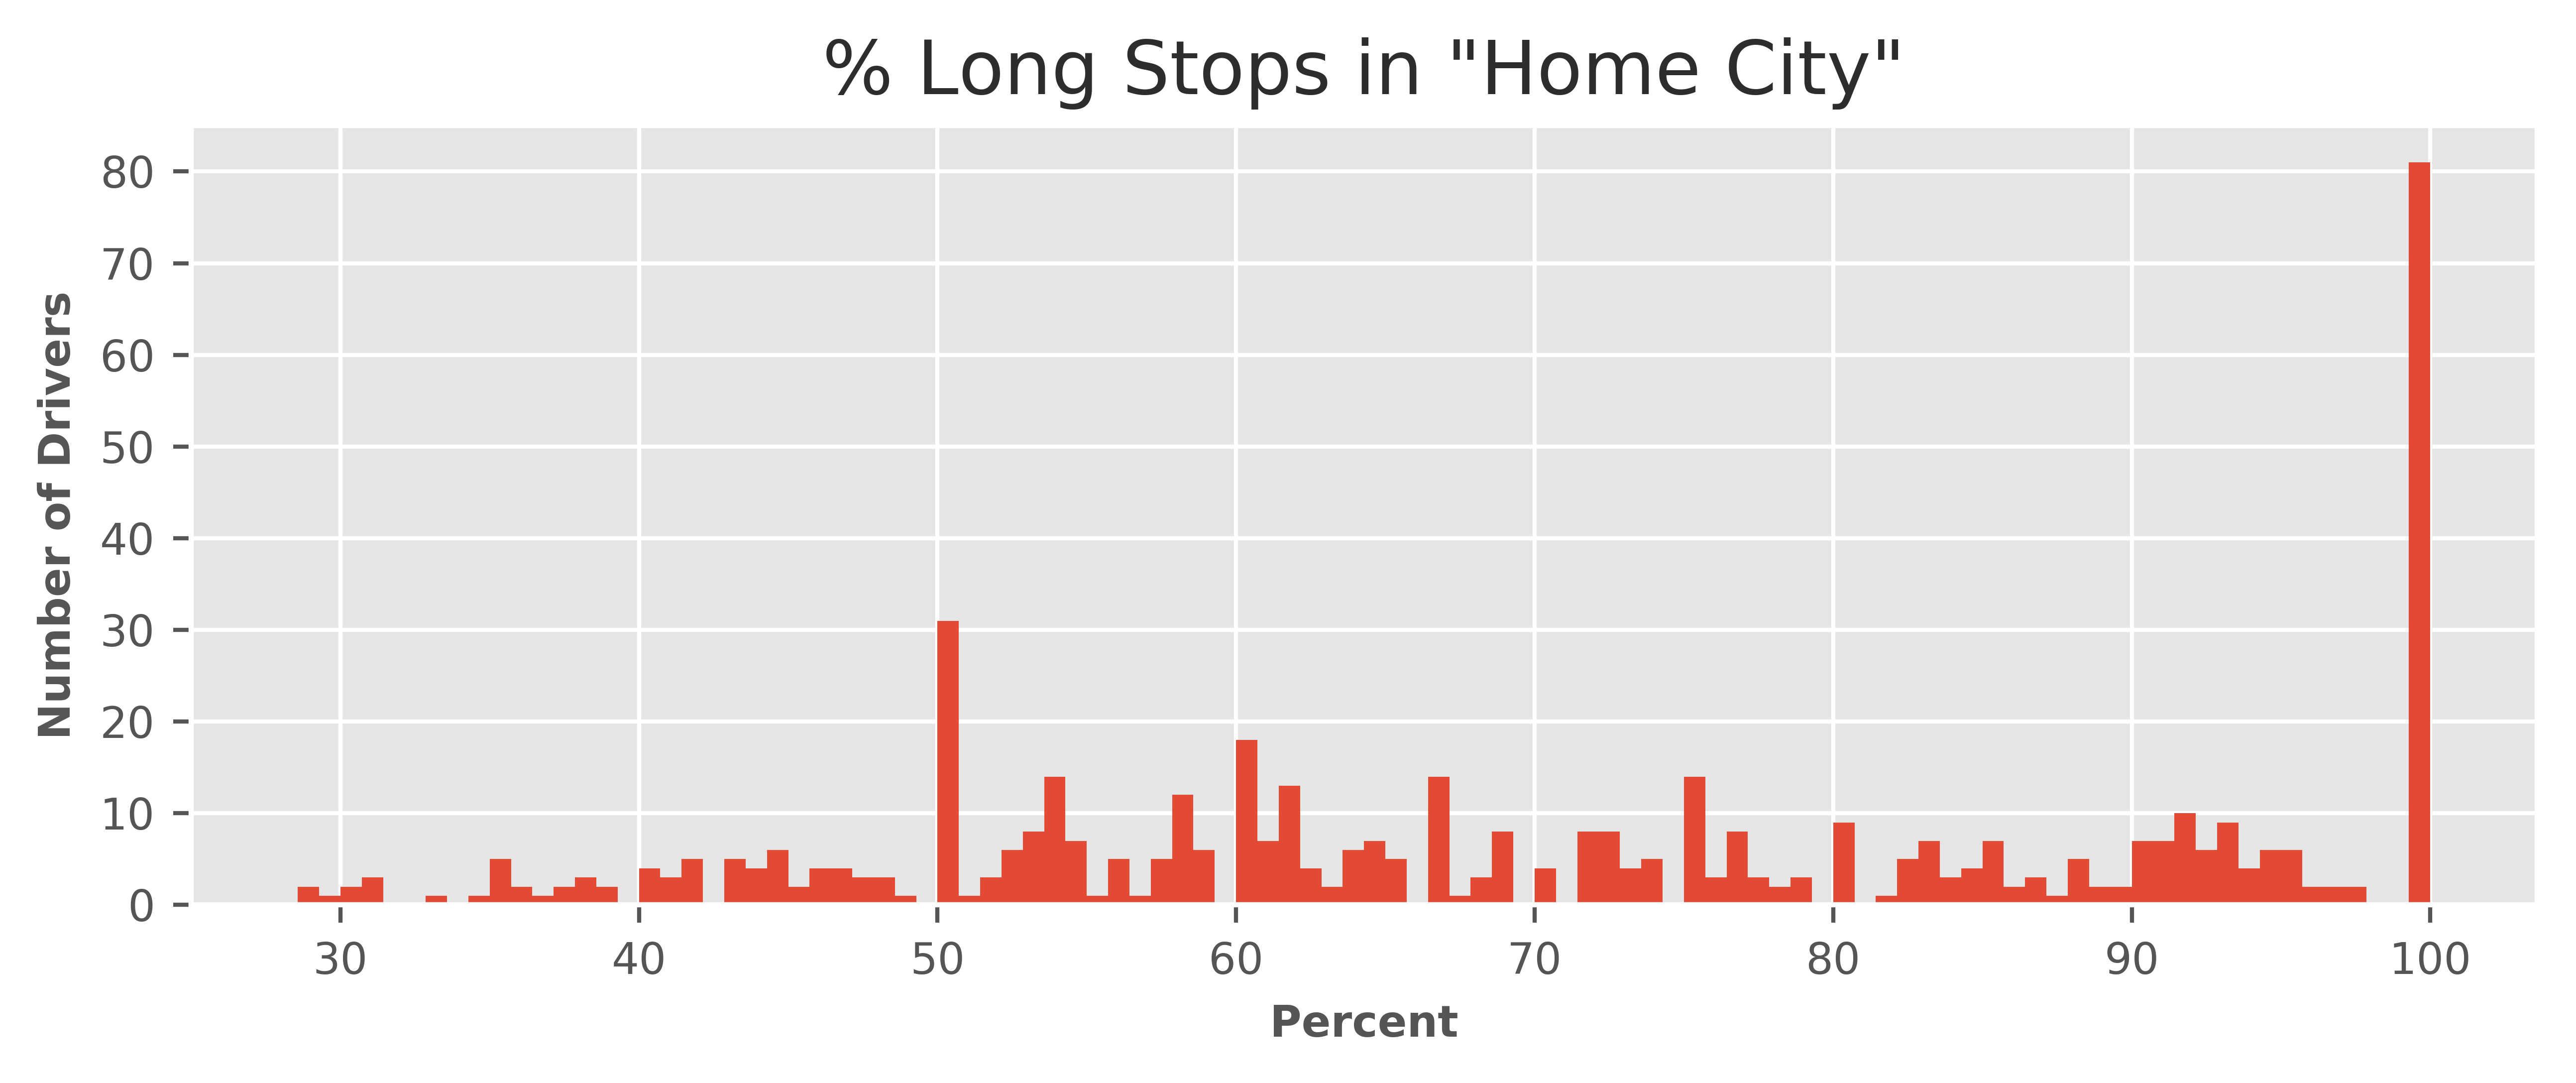

mean       71.23
median     69.23
min        28.57
max       100.00
count     512.00
dtype: float64
Total number of drivers: 977
Number of drivers with at least 10 long stops: 512


In [12]:
home_city_perc = uc_df.apply(lambda row: row.max()/row.sum()*100,axis=1)
df_plot(home_city_perc,'Percent','Number of Drivers',title='% Long Stops in "Home City"',plotstyle='hist',hist_max=100,bins=100)
print(home_city_perc.agg(['mean','median','min','max','count']).round(2))
print(f'Total number of drivers: {sp_df.userid.nunique()}')
print(f'Number of drivers with at least {min_ls} long stops: {home_city_perc.count()}')

## 2 Driver Classification

## Main Idea
* Simple driver classification based on **percentage (%) of long stops in home city**.
* 我用了司机在“home city"长停留的百分比简单的分类

* Classification criteria:
    * 90%+: **Short-haul**
    * 50-90%: **Mid-haul**
    * <50%: **Long-haul**

In [26]:
# Classify drivers
clf_df = clf.classify_drivers(user_city_df,short_min=0.9,mid_min=0.5)
#print('\nPreview first 5 classifications: ')
#print(clf_df.head())

Classifying drivers into haul types ... 
Function classify_drivers took 1.91s.


## 2.1 Short-haul

In [17]:
# Helper script
import visualize as vis
mpl.rcParams['figure.dpi'] = 1000

userids = vis.get_userids(sp_df,num_drivers=16,by_type='short_haul',clf_df=clf_df)
vis.show_plot('all_basic',sp_df,city_df,userids)

## 2.2 Long-haul

In [18]:
userids = vis.get_userids(sp_df,num_drivers=16,by_type='long_haul',clf_df=clf_df)
vis.show_plot('all_basic',sp_df,city_df,userids)

In [11]:
# To hide/show Code
from IPython.display import HTML
toggl = '''<script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Show/Hide Code"></form>'''
HTML(toggl)